# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Lecture 8: Trees and Forests

**Harvard University**<br>
**Summer 2021**<br>
**Instructors:** Kevin Rader<br>
**Authors:** Rahul Dave, David Sondak, Pavlos Protopapas, Chris Tanner, Eleni Kaxiras, Kevin Rader

---

# Table of Contents 
<ol start="0">
<li> Learning Goals </li>
<li> Decision Trees </li> 
<li> Bootstrap-Aggregated (Bagged) Trees </li> 
<li> Random Forests </li> 
   

    

## Learning Goals

This Jupyter notebook accompanies Lecture 8. By the end of this lecture, you should be able to:

- Be able to fit and visualize (through predictions) decision trees, bootstrap-aggregated (bagged) trees, and random forests. 
- Have a general sense of the difference between the 3 tree based methods.
- Tune the hyperparameters of a random forest.


In [16]:
%matplotlib inline
import sys
import numpy as np
import pylab as pl
import pandas as pd
import sklearn as sk
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn import tree

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier


import sklearn.metrics as met

from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 20)
plt.rcParams["figure.figsize"] = (12,8)

## Part 0: Reading and Exploring the data 

We will be using the same data as lectures 3-5 (both the train and test splits): modeling `votergap` from the 2016 election (Trump-Clinton) from many predictors in the `county_election` dataset.

We start by reading in the datasets for you and visualizing the main predictors for now: `minority`:

**Important note: use the training dataset for all exploratory analysis and model fitting.  Only use the test dataset to evaluate and compare models.**

In [17]:
elect_train = pd.read_csv("../data/county_election_20_train.csv")
elect_test = pd.read_csv("../data/county_election_20_test.csv")

#calculate the response: votergap
votergap_train = 100*(elect_train['biden_perc']-elect_train['trump_perc'])
votergap_test = 100*(elect_test['biden_perc']-elect_test['trump_perc'])
elect_train['votergap'] = votergap_train
elect_test['votergap'] = votergap_test

elect_train.head()

,fips,biden_count,trump_count,totalvotes,biden_perc,trump_perc,state,fipscode,county,population,...,nodegree,bachelor,inactivity,obesity,density,cancer,votergap16,trump16,clinton16,votergap
0,31037,1025,2636,3717,0.275760,0.709174,Nebraska,31037,Colfax County,10332,...,28.1,14.1,25.5,31.5,11.4,238.9,41.425,68.443,27.018,-43.341404
1,24019,6857,8764,15977,0.429179,0.548539,Maryland,24019,Dorchester County,32043,...,17.6,19.3,30.3,35.7,320.2,158.0,15.983,56.563,40.580,-11.935908
2,51019,12176,35600,48669,0.250180,0.731472,Virginia,51019,Bedford County,67154,...,11.8,26.3,24.0,33.1,8.9,293.2,49.412,72.484,23.072,-48.129199
3,45031,15220,16832,32417,0.469507,0.519234,South Carolina,45031,Darlington County,66445,...,19.5,16.1,32.5,37.7,36.8,270.2,3.735,50.523,46.788,-4.972700
4,5135,1398,5938,7566,0.184774,0.784827,Arkansas,5135,Sharp County,17664,...,18.5,10.6,31.4,37.3,28.6,330.4,54.278,74.593,20.315,-60.005287


/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/User

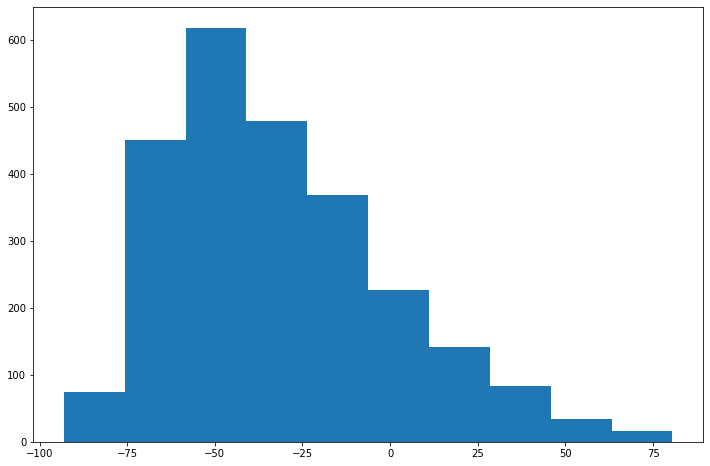

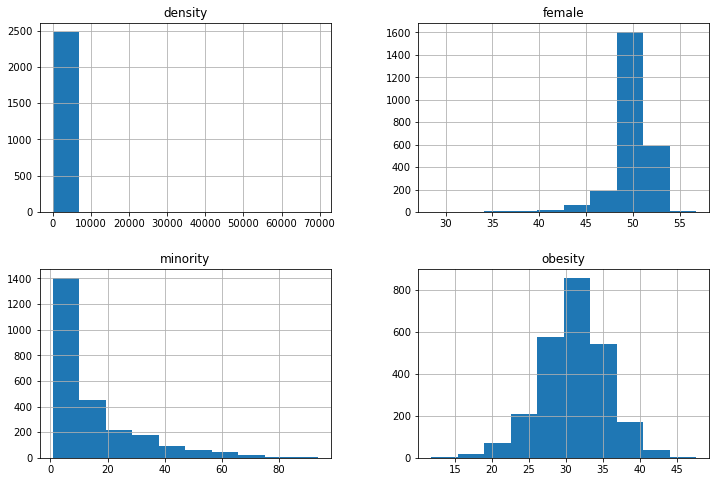

In [18]:
y_train = elect_train['votergap']
y_test = elect_test['votergap']

plt.hist(y_train)
elect_train.hist(column=['minority', 'density','obesity','female']);

**Q0.1** How would you describe these variables?  What issues does this create?  How can these issues be fixed?

**Answer:**

The response (`votergap`) is moderately left-skewed, while the predictors `density` and `minority` are extremely right-skewed (`obesity` is more or less symmetric, and `female` is moderately left-skewed like the response).  This extreme skewness hides the true relationship, and the sever outliers would have a lot of effect in models that rely on distance or influence metrics in the predictors space (like linear regression and k-NN regression).  They can be fixed with a log transformation.  Note: it does not affect the predictions for tree-based methods since the order of the observations is all that matter, on a log transformatoin is monotonic.

In [19]:
print(elect_train.shape)
print(elect_test.shape)

(2491, 25)
(623, 25)


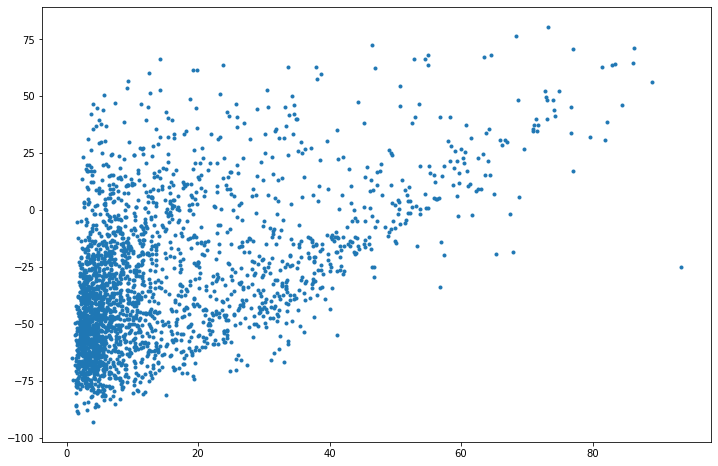

In [20]:
plt.plot(elect_train['minority'],y_train, '.');

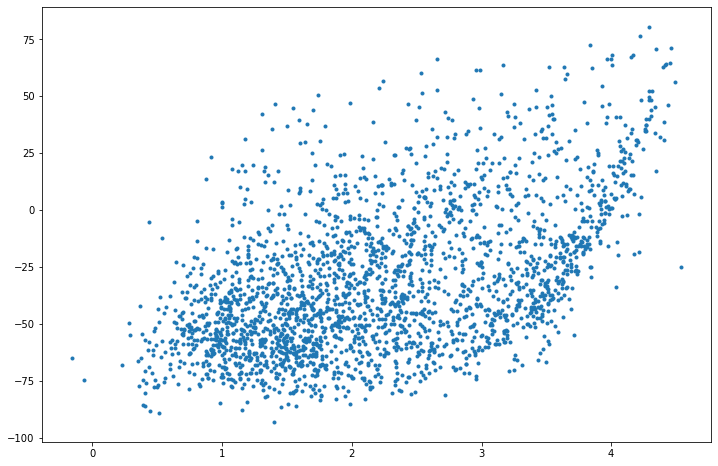

In [21]:
plt.plot(np.log(elect_train['minority']),y_train, '.');

**Q0.2** Which of the two versions of 'minority' would be a better choice to use as a predictor for inference?  For prediction?

**Answer:**

For inference or prediction in a parametric model (like linear regression), the log transform would be much better since the estimates would be less affected by outliers in the predictor space.  Inference is not really applicable to a tree-based model, and they are unafeected by this transformation (as mentioned above).  

---

## Part 1: Decision Trees

### Regression Tree Examples

We could use a simple Decision Tree regressor to predict `votergap`. That's not the aim of this lab, so we'll run a few of these models without any cross-validation or 'regularization' just to illustrate what is going on.

This is what you ought to keep in mind about decision trees.

from the docs:
```
max_depth : int or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split : int, float, optional (default=2)
```

- The deeper the tree, the more prone you are to overfitting.
- The smaller `min_samples_split`, the more the overfitting. One may use `min_samples_leaf` instead. More samples per leaf, the higher the bias (aka, simpler, underfit model).

Below we fit 2 decision treees that limit the `max_depth`: a single split, and one with 2 splits (resulting in 4 leaves).

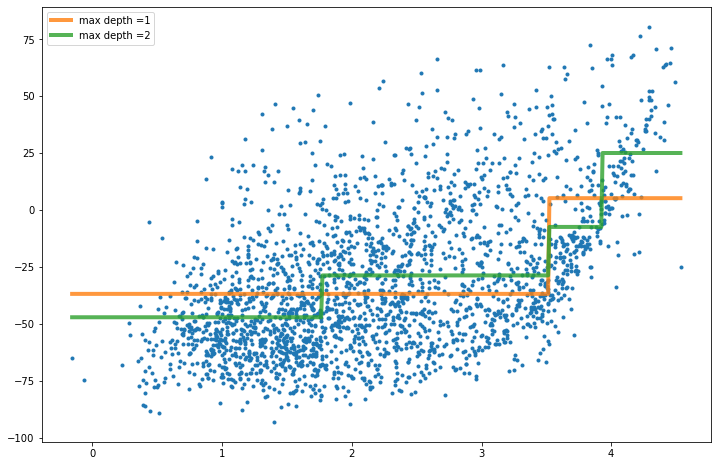

In [22]:
from sklearn.tree import DecisionTreeRegressor

elect_train['logminority'] = np.log(elect_train['minority'])
elect_test['logminority'] = np.log(elect_test['minority'])

dummy_x = np.arange(np.min(elect_train['logminority']),np.max(elect_train['logminority']),0.01)

plt.plot(elect_train['logminority'],y_train,'.')

for i in [1,2]:
    dtree = DecisionTreeRegressor(max_depth=i)
    dtree.fit(elect_train[['logminority']],y_train)
    plt.plot(dummy_x , dtree.predict(dummy_x.reshape(-1,1)), label=("max depth ="+str(i)), alpha=0.8, lw=4)

plt.legend();

And the actual decision tree can be *printed out* using [sklearn.tree.plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html):

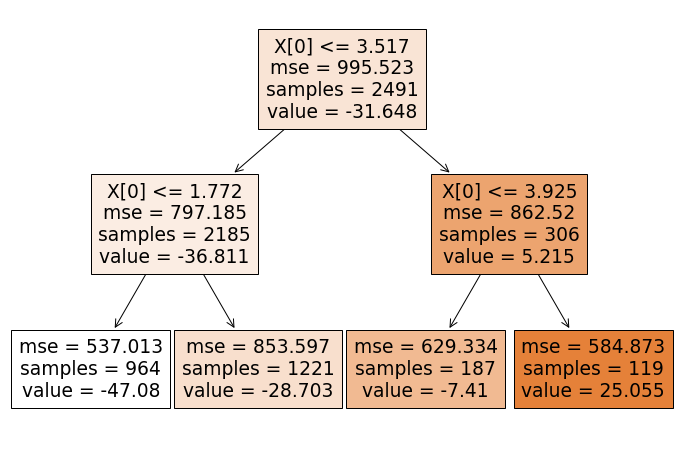

In [23]:
from sklearn import tree

tree.plot_tree(dtree, filled=True)
plt.show()

**Q1.1** Interpret the printed out tree above: how does it match the scatterplot visualization of the regression tree?

**Answer:**

The first split in the flow chart is `X[0] <= 3.517`, which is exactly where one of the jumps occurs in the two models in the scatterplot.  The 4 terminal nodes have predicted responses of 45.949, 29.589, 6.596, and -27.337, which match the height of the 4 regions' steps in the scatterplot.

**Q1.2** Play around with the various arguments to define the complexity of the decision tree: `max_depth`,`min_samples_split`, and `min_samples_leaf` (do 1 at a time for now, you can use multiple of these arguments).  Roughly, at what point do these start to overfit?

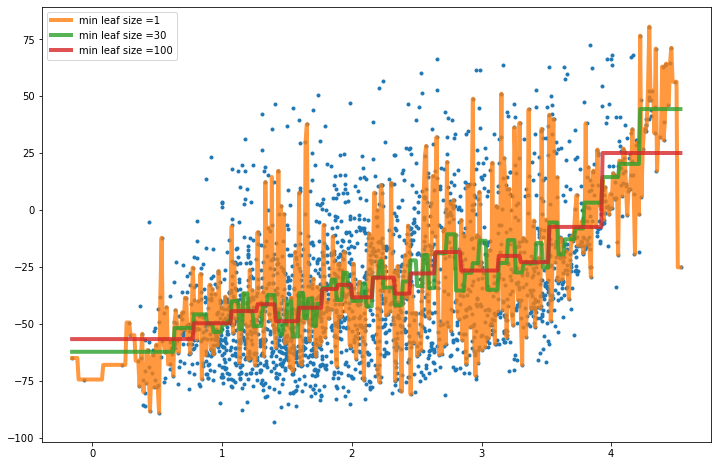

In [24]:
plt.plot(elect_train['logminority'],y_train,'.')

for i in [1,30,100]:
    dtree = DecisionTreeRegressor(min_samples_leaf=i)
    dtree.fit(elect_train[['logminority']],y_train)
    plt.plot(dummy_x , dtree.predict(dummy_x.reshape(-1,1)), label=("min leaf size ="+str(i)), alpha=0.8, lw=4)

plt.legend();

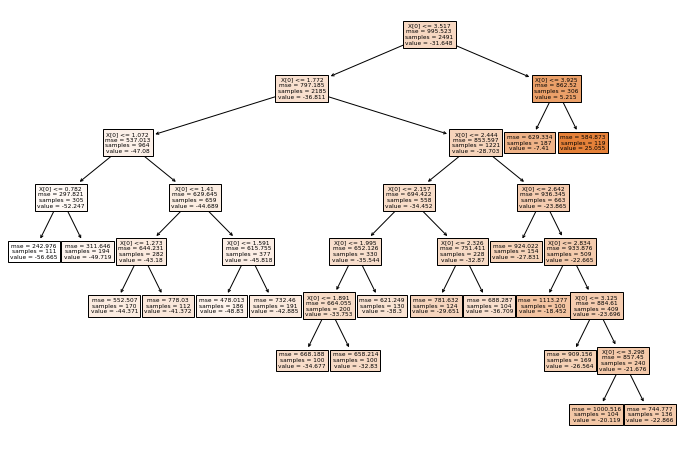

In [25]:
tree.plot_tree(dtree, filled=True)
plt.show()

**Answer:**

`max_depth` started to overfit a little at around 5 or 6 (visually speaking).  A `min min_samples_leaf` of 30 clearly overfits as well (see graph above).

**Q1.3** Perform 5-fold cross-validation to determine what the best `max_depth` would be for a single regression tree using the entire `X_train` feature set defined below.  We give you code to visualize the results with mean +/- 2 sd's across the validation sets.  Interpret the results.

In [26]:
from sklearn.model_selection import cross_val_score

elect_train['logdensity'] = np.log(elect_train['density'])
elect_train['loghispanic'] = np.log(elect_train['hispanic'])

elect_test['logdensity'] = np.log(elect_test['density'])
elect_test['loghispanic'] = np.log(elect_test['hispanic'])

X_train = elect_train[['logminority', 'logdensity','loghispanic','obesity','female','income','bachelor','inactivity']]
X_test = elect_test[['logminority', 'logdensity','loghispanic','obesity','female','income','bachelor','inactivity']]

# your code here
depths = list(range(1, 21))
trainscores = []
cvmeans = []
cvstds = []
cvscores = []

for depth in depths:
    dtree = DecisionTreeRegressor(max_depth=depth)
    # Perform 5-fold cross validation and store results
    trainscores.append(dtree.fit(X_train, y_train).score(X_train, y_train))
    scores = cross_val_score(estimator=dtree, X=X_train, y=y_train, cv=5)
    cvscores.append(scores)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())

cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

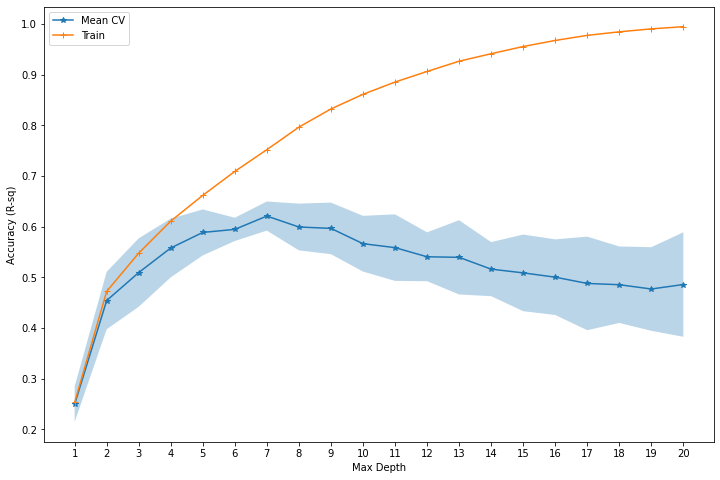

In [27]:
# Here we plot means and shade the 2 SD interval

plt.plot(depths, cvmeans, '*-', label="Mean CV")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
ylim = plt.ylim()
plt.plot(depths, trainscores, '-+', label="Train")
plt.legend()
plt.ylabel("Accuracy (R-sq)")
plt.xlabel("Max Depth")
plt.xticks(depths);

**Answer:**

Based on the plot above, it's clear that the training $R^2$ increases towards one as `max_depth` increases, while the test set's $R^2$ maxes out around 50% around a `max_depth` of 6. Any of those values would be reasonable to choose for a best predictive model.  To prevent overfitting and for parsimony, I would choose a `max_depth` of 6.  

### Classification Tree Example

Let's try to quickly build a classification tree instead (to predict whether votergap is positive...think: did the county favor Biden over trump).


In [28]:
elect_train['biden'] = 1*(votergap_train>0)
elect_test['biden'] = 1*(votergap_test>0)


**Q1.4** What percentage of counties voted in favor of Biden over Trump?  Is this surprising?

In [29]:
np.unique(elect_train['biden'],return_counts=True)

(array([0, 1]), array([2061,  430]))

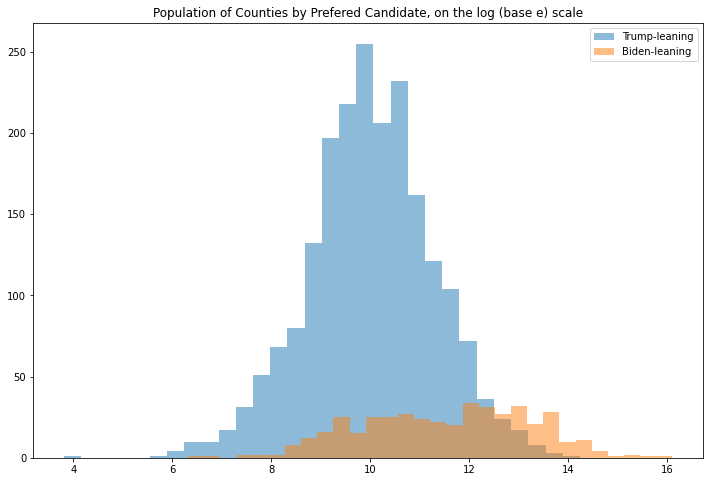

In [30]:
plt.hist(np.log(elect_train[elect_train['biden']==0]['population']), alpha=0.5, bins=30,label='Trump-leaning')
plt.hist(np.log(elect_train[elect_train['biden']==1]['population']), alpha=0.5, bins=30,label='Biden-leaning')
plt.title("Population of Counties by Prefered Candidate, on the log (base e) scale")
plt.legend();

$430/(2061+430) = 17.3\%$ of counties voted in favor of Biden.  This is surprising: over 80% of counties voted in favor of Trump, and despite this, Biden won the election!?  Quite suprising at first glance, but the smaller rural counties voted in favor of Trump, while the larger urban counties voted in favor ot Biden.

Let's fit a few decision trees (based on varying `min_samples_leaf`) to predict `biden` from `logminority`.  We then visualize the predicted probabilities in our usual prediction plot.  

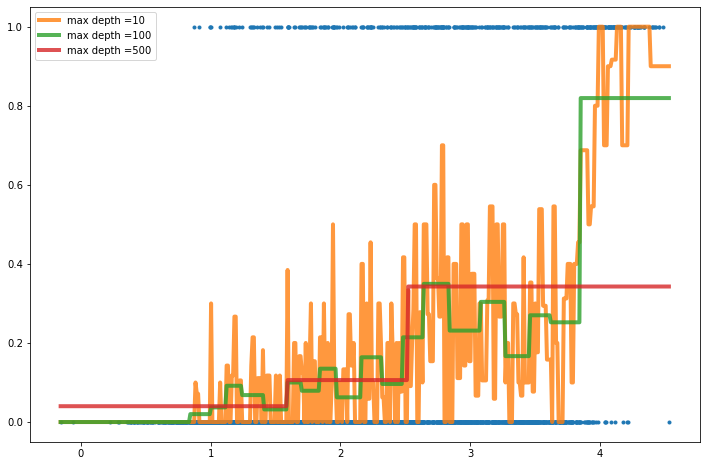

In [31]:
from sklearn.tree import DecisionTreeClassifier

dummy_x = np.arange(np.min(elect_train['logminority']),np.max(elect_train['logminority']),0.01)

plt.plot(elect_train['logminority'],elect_train['biden'],'.')

for i in [10,100,500]:
    dtree_class = DecisionTreeClassifier(min_samples_leaf=i)
    dtree_class.fit(elect_train[['logminority']],elect_train['biden'])
    plt.plot(dummy_x , dtree_class.predict_proba(dummy_x.reshape(-1,1))[:,1], label=("max depth ="+str(i)), alpha=0.8, lw=4)

plt.legend();

**Q1.5** What do these model show?  Which model is best?  What would be the classification boundary for each model?  In what ways do these models agree/disagree with the same general association seen in the regression decision trees?

*your answer here*

The general association is that the chances a county favors biden over trump is positively related to minority population (on the log scale) which agree with the same general trend frmo the Regression Decision Tree model.  The decision/classification boundary can easily be determined from this plot: just determine where the predicted probabilities jump over 0.5: for example, at roughly $log(minority) = 3.8 \implies minority \approx 45$ the model with `min_samples_leaf=100` jumps over 0.5, so values above that are classified to be in favor of Biden. The model with `min_samples_leaf=10` jumps over and below 0.5 several times, and the model with `min_samples_leaf=500` will always classify to the Trump-preferred group.

**Q1.6** Perform 5-fold cross-validation to determine what the best `min_samples_leaf` would be for a single classification tree using the entire `X_train` feature set defined below.  Visualize the results with mean +/- 2 sd's across the validation sets.  Interpret the result.  

In [32]:
#the same X as before
X_train = elect_train[['logminority', 'logdensity','loghispanic','obesity','female','income','bachelor','inactivity']]
X_test = elect_test[['logminority', 'logdensity','loghispanic','obesity','female','income','bachelor','inactivity']]

# your code here
leaves = [5,10,20,50,100,200,500]
trainscores = []
cvmeans = []
cvstds = []
cvscores = []

for leaf in leaves:
    dtree = DecisionTreeClassifier(min_samples_leaf=leaf)
    trainscores.append(dtree.fit(X_train, elect_train['biden']).score(X_train, elect_train['biden']))
    scores = cross_val_score(estimator=dtree, X=X_train, y=elect_train['biden'], cv=5)
    cvscores.append(scores)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())

cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

In [33]:

# your code here
# plot means and shade the 2 SD interval




In [34]:
print("Best choice for leaf size = ", leaves[np.argmax(cvmeans)])

Best choice for leaf size =  50


*your answer here*

Leaf size of 50 seems to be the best choice, but leaf sizes of 20 and even 10 perform similarly.  We could certainly do a better job of honing in on a more appropriate 'best' leaf size

Ok with this discussion in mind, lets improve the Decision Tree models by Bagging (we'll focus on the regression models).

## Part 2: Bootstrap-Aggregating (called Bagging)

Whats the basic idea?

- A Single Decision tree is likely to overfit and is very 'jumpy' (discrete step-function).
- So lets introduce replication through Bootstrap sampling.
- **Bagging** uses bootstrap resampling to create different training datasets. This way each training will give us a different tree.
- Added bonus: the left off points can be used to as a natural "validation" set, so no need to 
- Since we have many trees that we will **average over for prediction**, we can choose a large `max_depth` and we are ok as we will rely on the law of large numbers to shrink this large variance, low bias approach for each individual tree.

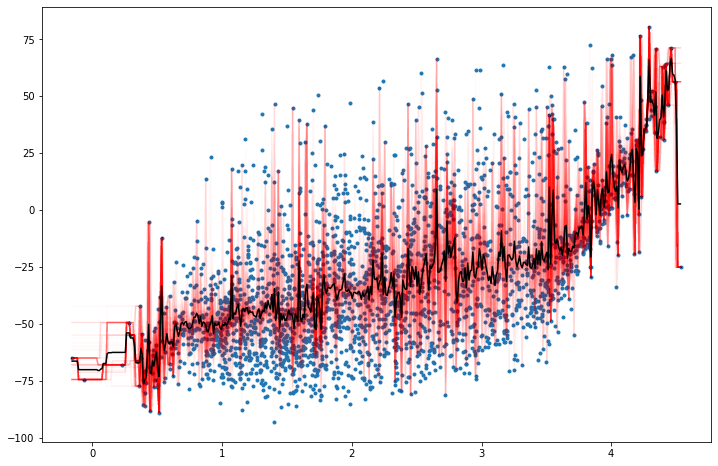

In [35]:
from sklearn.utils import resample

ntrees = 200
estimators = []
R2s = []
yhats_test = np.zeros((X_test.shape[0], ntrees))
yhats_dummy = np.zeros((dummy_x.shape[0], ntrees))

plt.plot(elect_train['logminority'],y_train,'.')

for i in range(ntrees):
    simpletree = DecisionTreeRegressor(max_depth=10)
    boot_x, boot_y = resample(X_train[['logminority']], y_train)
    estimators = np.append(estimators,simpletree.fit(boot_x, boot_y))
    R2s = np.append(R2s,simpletree.score(X_test[['logminority']], y_test))
    yhats_test[:,i] = simpletree.predict(X_test[['logminority']])
    yhats_dummy[:,i] = simpletree.predict(dummy_x.reshape(-1,1))
    plt.plot(dummy_x, simpletree.predict(dummy_x.reshape(-1,1)), 'red', alpha=0.02)
    
plt.plot(dummy_x,np.mean(yhats_dummy,axis=1),'black');

**Q2.1** Interpret the plot above: how does bagging improve a single decision tree?  How could the resulting models be used to perform prediction?  Should the base trees be underfit, overfit, or just right?

**Answer:**

The plot above shows that all the individual trees are clearly overfit to the train set, but when averaged, the predictions visually appear more smooth, and the mean predictions (across the 200 separate base trees) illustraes this as well (though there is still some jumpiness in the aggreegated predictions.

**Q2.2** Do lots of work here:
1. Edit the code below (which is just copied from above) to refit many bagged trees on the entire `X_train` feature set (without the plot...lots of predictors now so difficult to plot). 
2. Summarize how each of the separate trees performed (both numerically and visually) using $R^2$ as the metric.  How do they perform on average?
3. Combine the trees into one prediction and evaluate it using $R^2$.
4. Briefly discuss the results.  How will the results above change if 'max_depth' is increased?  What if it is decreased?

Average R-squared score of the individual trees: 0.5837060420546438
R-squared score of the aggregated trees: 0.6964109711462372


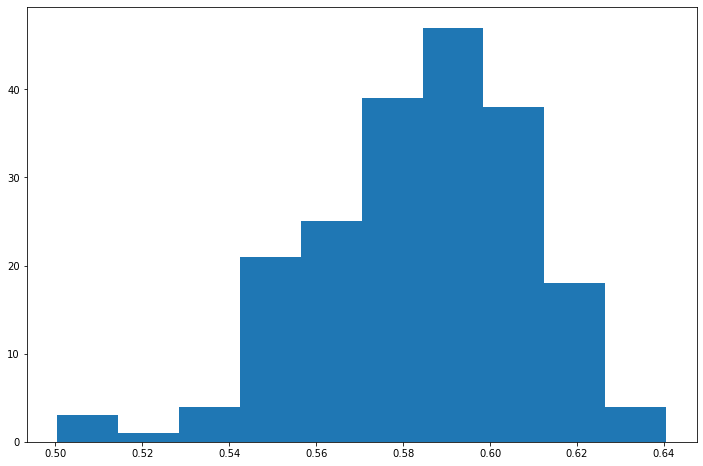

In [36]:
from sklearn.metrics import r2_score

ntrees = 200
estimators = []
R2s = []
y_hats_test = np.zeros((X_test.shape[0], ntrees))

for i in range(ntrees):
    simpletree = DecisionTreeRegressor(max_depth=7)
    boot_x, boot_y = resample(X_train, y_train)
    estimators = np.append(estimators,simpletree.fit(boot_x, boot_y))
    R2s = np.append(R2s,simpletree.score(X_test, y_test))
    y_hats_test[:,i] = simpletree.predict(X_test)

# your code here
#let's look at how the bagging does:
plt.hist(R2s);
print("Average R-squared score of the individual trees:", np.mean(R2s))

bagged_test_predictions = np.mean(y_hats_test, axis=1)
print("R-squared score of the aggregated trees:",r2_score(y_test,bagged_test_predictions))


**Answer**:

Notice that the aggregated results, by averaging the predictions across the 500 different Regression Tree models, scores and $R^2$ in the test set of 68% which outperforms all of the separate individual models.  We would expect this to improve further for larger values of `max_depth`, and in fact should imrpove quite a lot.  This Bagging improves the variability of 'high variance' models by leveraging the law of large numbers, but does not improve bias nearly as much.  Essentially, it is an indirect way of 'smoothing' these discretized step function by essentially jittering where those jumps occur.  See the visual above.  If we do change `max_depth` to something larger in the code above, we do see quite an improvement in predictive ability in the test set.  A `max_depth` of 20 led to a test $R^2$ of 71.1%, for example.



## Part 3: Random Forests

What's the basic idea?

Bagging alone is not enough randomization, because even after bootstrapping, we are mainly training on the same data points using the same variables, and will retain much of the overfitting.

So we will build each tree by splitting on "random" subset of predictors at each split (hence, each is a 'random tree').  This can't be done in with just one predcitor, but with more predictors we can choose what predictors to split on randomly and how many to do this on.  Then we combine many 'random trees' together by averaging their predictions, and this gets us a forest of random trees: a **random forest**.

Here are the parameters we can play with:

```
max_features : int, float, string or None, optional (default=”auto”)
- The number of features to consider when looking for the best split.
```

- `max_features`: Default splits on all the features and is probably prone to overfitting. You'll want to validate on this. 
- You can "validate" on the trees `n_estimators` as well but many times you will just look for the plateau in the trees as seen below.
- From decision trees you get the `max_depth`, `min_samples_split`, and `min_samples_leaf` as well, but you can leave those at defaults to get a maximally expanded tree.

Let's start by fitting a single attempt at a random forest, with `n_estimators` = 50, `max_features` = 0.33, and `max_depth` = 20:

In [37]:
from sklearn.ensemble import RandomForestRegressor

rf1 = RandomForestRegressor(oob_score=True, n_estimators=50, max_features=0.33, max_depth=20)
rf1.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, max_features=0.33, n_estimators=50,
                      oob_score=True)

In [38]:
X_train.shape

(2491, 8)

**Q3.1** What is the predicted votergap for 'Middlesex County' in 'Massachusetts' (in the training set) for this random forest model?  Determine $R^2$ in the test set for this random forest model.  

In [39]:

#this will be helpful
X_train[(elect_train['state']=='Massachusetts') & (elect_train['county']=='Middlesex County')]

######
# your code here
######

print("Middlesex, MA is predicted to be",rf1.predict(X_train[(elect_train['state']=='Massachusetts') & (elect_train['county']=='Middlesex County')]))

met.r2_score(y_test,rf1.predict(X_test))

Middlesex, MA is predicted to be [33.95289208]


0.7138168691106319

**Q3.2** Play around with the 3 hyperparameters to try to improve the predictive ability of the random forest (call it `rf2`).  How much has this improved the $R^2$ in the test set?  What parameters did you settle on?  

In [40]:
######
# your code here
######


rf2 = RandomForestRegressor(oob_score=True, n_estimators=500, max_features=0.75, max_depth=50).fit(X_train, y_train)
met.r2_score(y_test,rf2.predict(X_test))

0.723711089892993

**Answer:**

We can improve things here by making sure we have enough base trees (500 should be enough), we increase the maximum number of predictors considered at each split of the trees (since there are only a few predictors (8), considering just 1/3 of them at each split is too simple), and starting off with a more complex, deeper model.

Let's automate this process: below we create a hyper-param Grid. We are preparing to use the bootstrap points not used in training for validation rather than having to 'lose observations' in train by doing standard cross-validation.


In [41]:
# code from 
# Adventures in scikit-learn's Random Forest by Gregory Saunders
from itertools import product
from collections import OrderedDict
param_dict = OrderedDict(
    n_estimators = [100, 300, 500],
    max_features = [0.4, 0.5, 0.6, 0.7, 0.8]
)

param_dict.values()

odict_values([[100, 300, 500], [0.4, 0.5, 0.6, 0.7, 0.8]])

### Using the OOB score.

We have been putting "validate" in quotes. This is because the bootstrap gives us left-over points! So we'll now engage in our very own version of a grid-search, done over the out-of-bag scores that `sklearn` gives us for free

In [42]:
from itertools import product

In [43]:
# make sure y_train is the correct data type...in case you have warnings
# print(y_train.shape,X_train.shape)
# y_train = np.ravel(y_train)
# note: n_jobs=-1` parallelizes the process to use all your CPU threads

#Let's Cross-val. on the two 'hyperparameters' we based our grid on earlier
results = {}
estimators= {}
for ntrees, maxf in product(*param_dict.values()):
    params = (ntrees, maxf)
    est = RandomForestRegressor(oob_score=True, 
                                n_estimators=ntrees, max_features=maxf, max_depth=50, n_jobs=-1)
    est.fit(X_train, y_train)
    results[params] = est.oob_score_
    estimators[params] = est
outparams = max(results, key = results.get)
outparams

(300, 0.7)

In [44]:
rf_best = estimators[outparams]

In [45]:
results

{(100, 0.4): 0.7437787780393157,
 (100, 0.5): 0.7431476152129755,
 (100, 0.6): 0.7450213914139827,
 (100, 0.7): 0.7495070848870813,
 (100, 0.8): 0.7446966741684912,
 (300, 0.4): 0.7486230925373711,
 (300, 0.5): 0.7515868163741966,
 (300, 0.6): 0.7503885105596068,
 (300, 0.7): 0.752125500940037,
 (300, 0.8): 0.7508728600891046,
 (500, 0.4): 0.7485713336094797,
 (500, 0.5): 0.7510060772881306,
 (500, 0.6): 0.749908061209637,
 (500, 0.7): 0.7511614200939122,
 (500, 0.8): 0.7493434070699447}

In [46]:
rf_best.score(X_test, y_test)

#Note: the score on the test set is worse than what we would expect from the OOB scores...this is a common result.

0.7269455274241567

Finally you can find the **feature importance** of each predictor in this random forest model. Whenever a feature is used in a tree in the forest, the algorithm will log the decrease in the splitting criterion (such as gini). This is accumulated over all trees and reported in `est.feature_importances_`

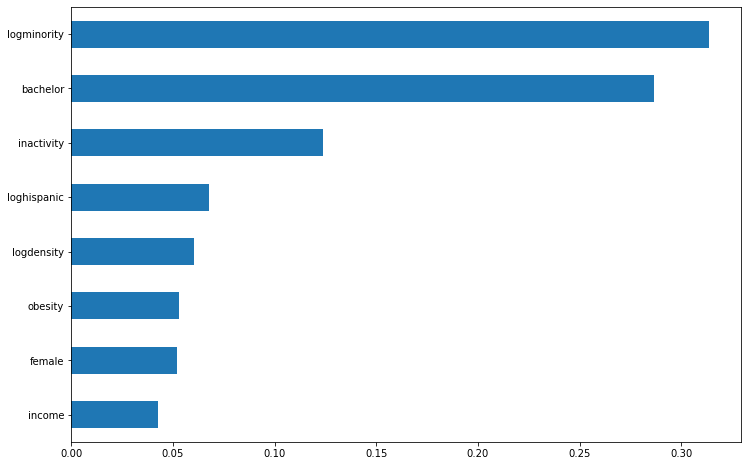

In [47]:
pd.Series(rf_best.feature_importances_,index=list(X_train)).sort_values().plot(kind="barh");

Since our response isn't very symmetric, we may want to suppress outliers by using the `mean_absolute_error` instead. 

In [48]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, rf_best.predict(X_test))

13.108591286480472

**Q3.3** Tune the 'RandomForestRegressor' above to minimize 'mean_absolute_error' instead of the default ____________

*Note: `sklearn` supports this (`criterion='mae'`), but does not have completely arbitrary loss functions for Random Forests.*


In [49]:
# your code here

# Note: there were estimation/convergence issues using MAE with CV, 
# so just one example is provided below.
rf_mae = RandomForestRegressor(oob_score=True, criterion='mae',
                                n_estimators=300, max_features=0.6, max_depth=50, n_jobs=-1)
rf_mae.fit(X_train, y_train)

RandomForestRegressor(criterion='mae', max_depth=50, max_features=0.6,
                      n_estimators=300, n_jobs=-1, oob_score=True)

In [50]:
#rf_mae = estimators[outparams]
print(mean_absolute_error(y_test, rf_mae.predict(X_test)))
print(rf_mae.score(X_test, y_test))

13.385537244956929
0.7176083102061741


This model would be expected to perform better in the test set when measuring mean absolute error, but not as good at mean squared error (but this is not guaranteed).  Here, we do not cross-validate, so that might explain why mean absolute error is worse.

Note: instead of using oob scoring, we could do cross-validation (with GridSearchCV), and a cv of 3 will roughly be comparable (same approximate train-vs.-validation set sizes). But this will take much more time as you are doing the fit 3 times plus the bootstraps. So at least three times as long!

In [51]:
param_dict2 = OrderedDict(
    n_estimators = [400,600,800],
    max_features = [0.2, 0.4, 0.6, 0.8]
)

In [52]:
from sklearn.model_selection import GridSearchCV
est2 = RandomForestRegressor(oob_score=False)
gs = GridSearchCV(est2, param_grid = param_dict2, cv=3, n_jobs=-1)
gs.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=OrderedDict([('n_estimators', [400, 600, 800]),
                                     ('max_features', [0.2, 0.4, 0.6, 0.8])]))

In [53]:
rf2 = gs.best_estimator_
rf2

RandomForestRegressor(max_features=0.8, n_estimators=800)

In [54]:
gs.best_score_

0.7455830196245629

**Q3.4** What are the 3 *hyperparameters* for a random forest (one of the hyperparameters come in many *flavors*)?  Which hyperparameters need to be tuned? 


*your answer here*

1. The 3 hyperparameters are `max_features`,  `max_depth` (or something related, like `min_samples_split`, so control the complexity of each tree), and `n_estimators` (in classification, the splitting criteria is another one you could consider)

2. `max_features` and  `max_depth` need to be tuned, while the higher `n_estimators` the better, generally (though there is clearly diminishing return, so just use someting 'largish' in the hundreds).  The best tuned `max_features` and `max_depth` will depend on the number of predictors you are considering, the number of observations in the training set, and whether it is a regression or a classification problem, and just how powerful the predictors are (for example, if a single predictor is the only important one, then `max_features` should be closer to 1).  There are lots of rules of thumb out there, but cross-validate if you can.

### Seeing error as a function of the proportion of predictors at each split

Let's look to see how `max_features` affects performance on the training set.

In [55]:
# from http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

feats = param_dict['max_features']
# 
error_rate = OrderedDict((label, []) for label in feats)

# Range of `n_estimators` values to explore.
min_estimators = 50
step_estimators = 50
num_steps = 6
max_estimators = min_estimators + step_estimators*num_steps
for label in feats:
    for i in range(min_estimators, max_estimators+1, step_estimators):
        clf = RandomForestRegressor(oob_score=True, max_features=label)
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

In [56]:
print(feats)

[0.4, 0.5, 0.6, 0.7, 0.8]


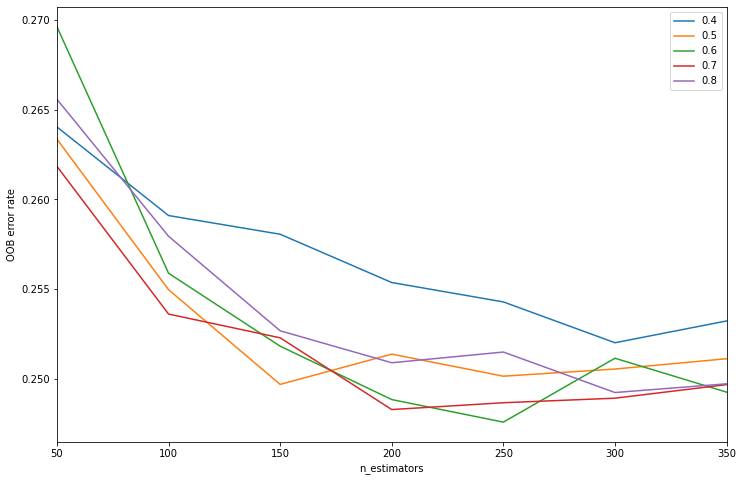

In [57]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

This plot just illustrates the 'diminishing returns' for increasing the number of base trees to aggregate over.  For this dataset and model, everything levels out once you get to about 200-300 trees as the basis for the forest.